# Power-of-Cosine Characteristic

In chapter 2.2, proportionalities of the gain $g(\vec r)$ were measured. It was found that
\begin{align}
g(r,\theta,\phi) \propto \frac{(cos\theta)^2 (cos\phi)^{32}}{r^2}
\end{align}
We will try that directivity on real data.

loaded data with shape torch.Size([1022, 192, 983])


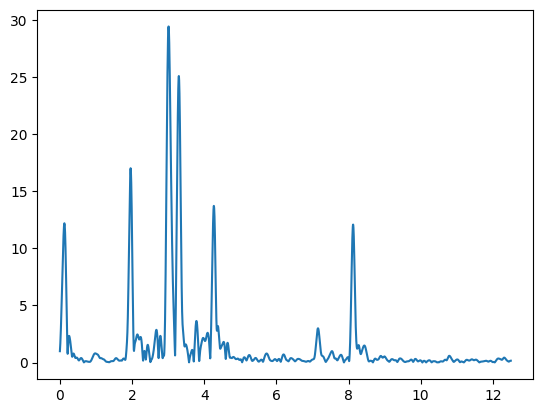

In [32]:
import os
os.chdir('/home/dgotzens/scripts/')

from timedataparser import load_all
from torch.fft import fft,ifft,fftshift,ifftshift
import matplotlib.pyplot as plt
import tools, torch
import numpy as np

header,_,data,_,params = load_all('/home/dgotzens/recording/exports_stability/23-10-09/', loadfeparams=True)
data = data[:,:,5]
nfft = 2**13
ranges = tools.ranges(header,nfft)
plt.plot(ranges[:nfft//2], tools.rangedata(data[:,0])[:nfft//2].abs(), label='9.10.')

In [33]:
M,K = data.shape
c0 = 299_792_458
π = torch.pi
β = 2*π*params['RampSlope']
ω0 = 2*π*header['RampLowFrequency']
fs = 22e6
Ts = 1/fs

X,Y,Z = 1,160,240
N = X*Y*Z
points = torch.zeros((3, N))
for n in range(Z):
    for m in range(Y):
        points[1,Y*n+m] =  8.0 * m/Y - 4
        points[2,Y*n+m] = 12.0 * n/Z

tau = torch.empty((K,N))
rx = torch.tensor([params['rxPosX'], params['rxPosY'], [0]*K]).T.unsqueeze(-1)
tx = torch.tensor([params['txPosX'], params['txPosY'], [0]*K]).T.unsqueeze(-1)

print(rx.shape, points.shape, (rx-points).shape)

dist = (rx-points).square().sum(1).sqrt() + (tx-points).square().sum(1).sqrt() 
tau = dist / c0

print(dist.shape)

torch.Size([192, 3, 1]) torch.Size([3, 38400]) torch.Size([192, 3, 38400])
torch.Size([192, 38400])


torch.Size([192, 38400]) torch.Size([1022, 192])
38400


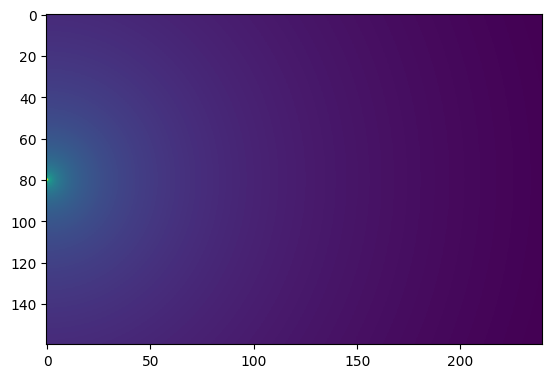

In [43]:
# far-field assumption
R = points.square().sum(0).sqrt().clamp(0.001,1000)
phi = torch.asin(points[0,:]/R)
theta = torch.acos(-points[1,:]/R)

# amp = torch.cos(theta)**2 * torch.cos(phi)**32 / R**2
amp = torch.cos(theta)**2 * torch.cos(phi)**32 
phase = (ω0 + 0.5*β*tau) * tau

gain = amp * torch.exp(1j*phase)
print(gain.shape, data.shape)
print(N)
img = torch.empty((Y,Z))
for n in range(N):
    img[n%Y,n//Y] = R[n]**(-2)
plt.imshow(img.log10())
plt.show()

\begin{align}
    \hat F(\vec r) & = \frac{1}{K}\sum_{k=0}^{K-1}G_k^\ast(\vec r)
    \sum_{m=0}^{M} e^{+j\dot\omega\tau_k(\vec r_S)mT_s} y_k[m]                
\end{align}

In [37]:
img = torch.empty((Y,Z))
for n in range(N):
    exp = torch.exp(1j*β*tau[:,n].unsqueeze(-1) * torch.arange(M)*Ts)
    img[n%Y,n//Y] = torch.mean(gain[:,n].unsqueeze(1).conj() * exp * data.H).abs()

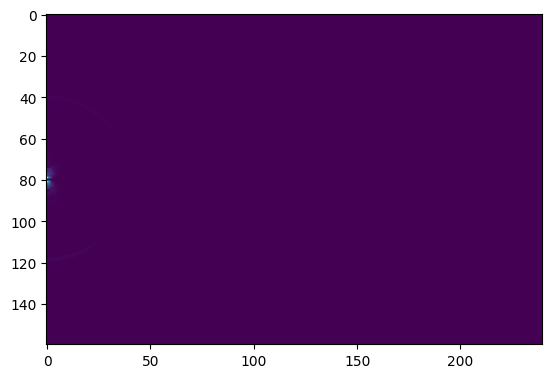

In [38]:
plt.imshow(img)
plt.show()